In [1]:
import json, os, cv2
import numpy as np

import torch
import torchvision

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import sys
sys.path.append('../src/')

from transform import *

In [3]:
PATH_IMG = '../data/train'
JSON_FILE = '../data/train.json'
WEIGHT_PATH = '../checkpoint'

np.random.seed(19)

In [4]:
with open(JSON_FILE,'r') as f:
    masks = json.load(f)

In [5]:
filename = list(masks.keys())[:200]

In [6]:
image_name = np.random.choice(filename, 5)

In [7]:
def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

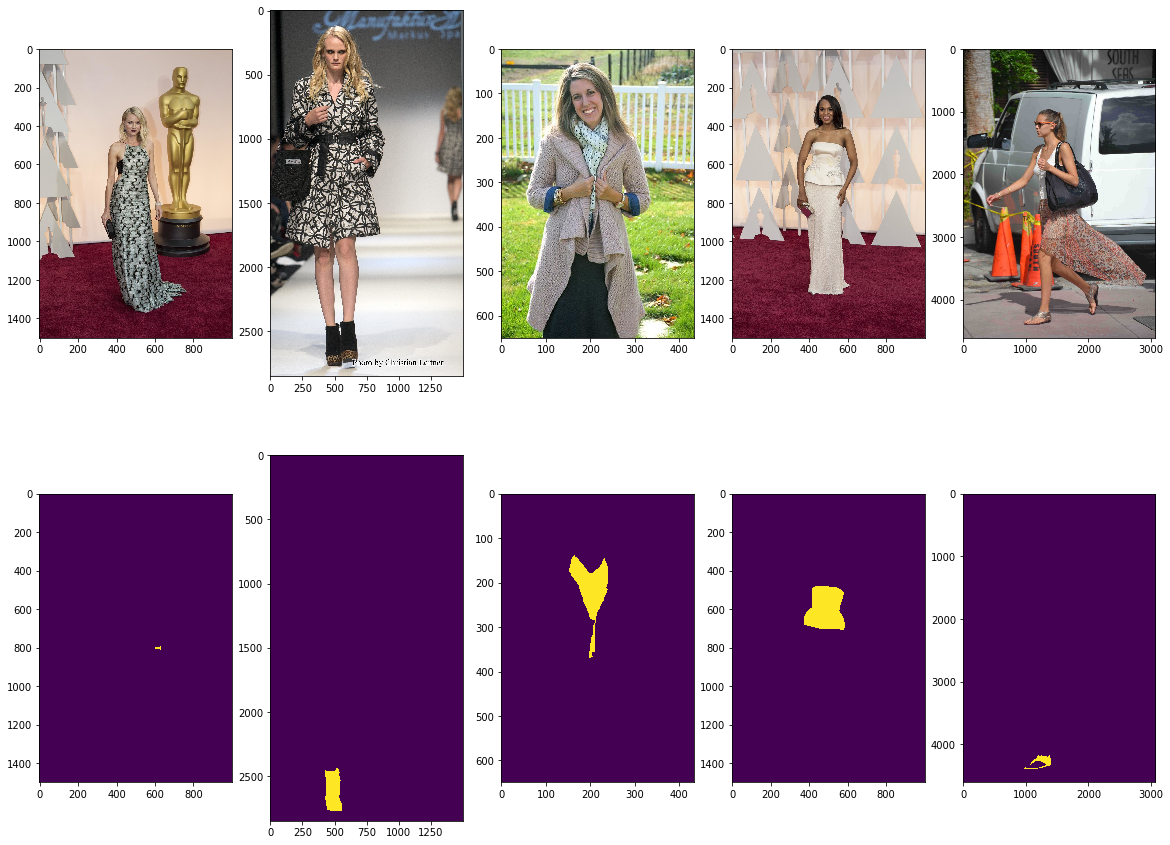

In [8]:
plt.figure(figsize=(20,15))
for i, name in enumerate(image_name):
    plt.subplot(2,5,i+1)
    image = cv2.imread(os.path.join(PATH_IMG, name), 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    
# show 1st mask:
for i, name in enumerate(image_name):
    plt.subplot(2,5,i+6)
    msk = rle_decode(masks[name]['mask'][0][1],
                     (masks[name]['Height'], masks[name]['Width']))
    plt.imshow(msk)

In [9]:
deeplabv3 = torchvision.models.segmentation.deeplabv3_resnet50(False)
fcn = torchvision.models.segmentation.fcn_resnet50(False)

deeplabv3.classifier[-1] = torch.nn.Conv2d(deeplabv3.classifier[-1].in_channels, 46, 1)
fcn.classifier[-1] = torch.nn.Conv2d(fcn.classifier[-1].in_channels, 46, 1)

state_dict = torch.load(os.path.join(WEIGHT_PATH, 'fcn_resnet50.pth'), map_location='cpu')
fcn.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
@torch.no_grad()
def model_preds(model, image_name):
    plt.figure(figsize=(20,10))
    h, w = masks[image_name]['Height'], masks[image_name]['Width']
    
    image = cv2.imread(os.path.join(PATH_IMG, image_name), 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256), cv2.INTER_AREA)
    plt.subplot(2,4,1)
    plt.imshow(image)

    for i, msk in enumerate(masks[image_name]['mask'], start=1):
        if i > 3: break
        plt.subplot(2,4,i+1)
        msk = rle_decode(msk[1], (h, w))
        msk = cv2.resize(msk, (256,256), cv2.INTER_NEAREST)
        plt.imshow(msk)
        
    preds = model(infer_transform(image)[None])['out']
    preds = preds[0]
    i = 2
    for m in preds:
        if i > 4: break
        if (m > 0).float().sum() > 10:
            plt.subplot(2,4,i+4)
            plt.imshow((m > 0).float().numpy(), cmap='gray')
            i += 1

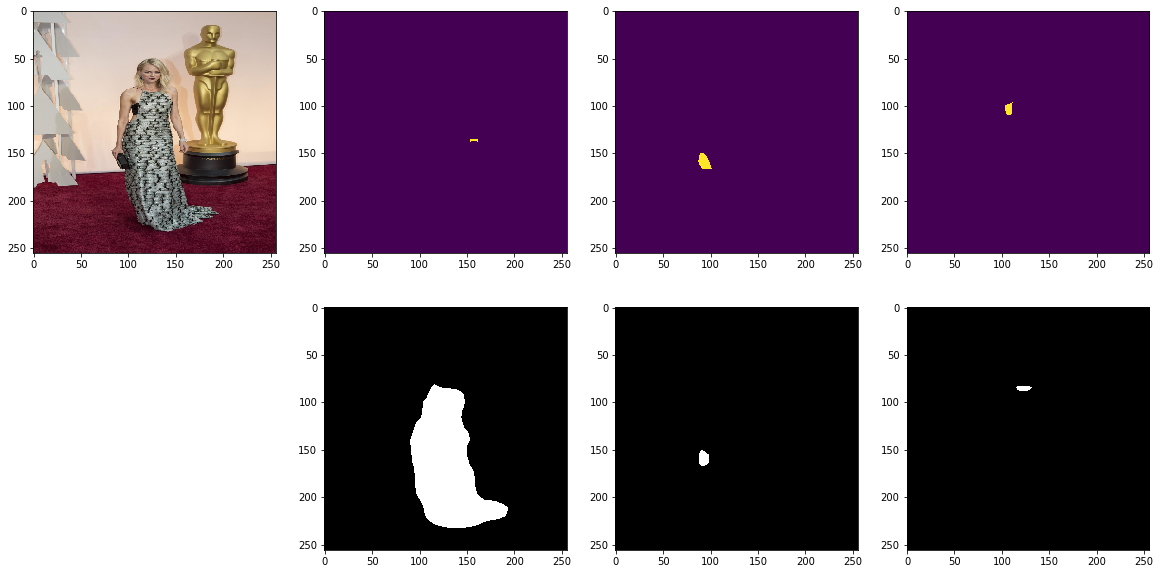

In [11]:
model_preds(fcn, image_name[0])

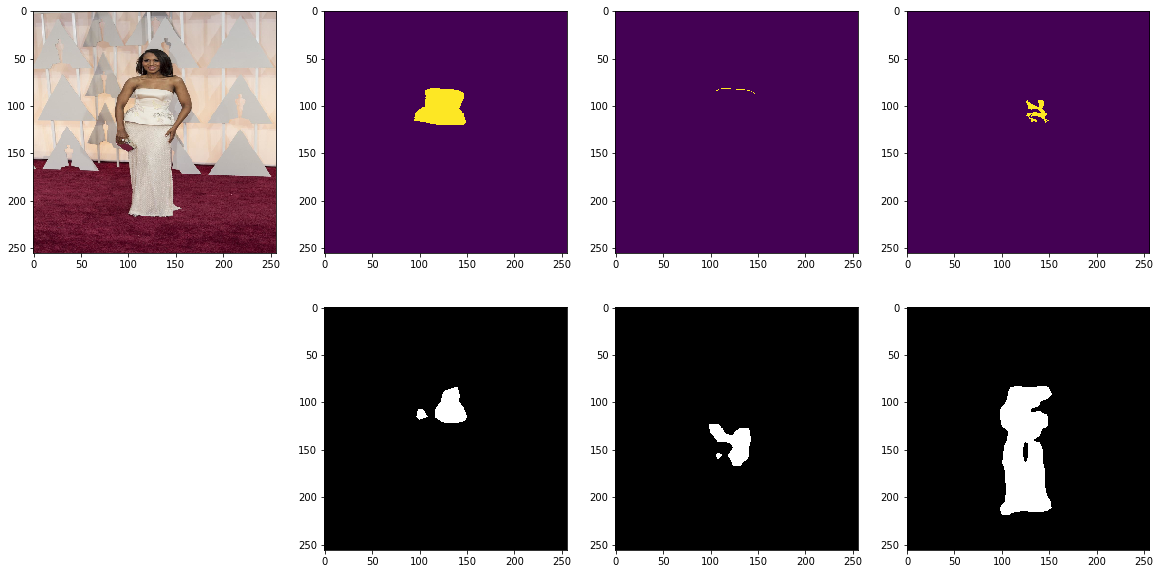

In [12]:
model_preds(fcn, image_name[3])